# The probability of a player scoring in a game based on the player and the opposing team

Our project aimed to gain a deeper understanding of a hockey player's scoring potential by focusing on past relevant data. We were able to uncover the player's intricacies by examining correlating features such as their position on the ice and the amount of successfully scored goals.

In [ ]:
# Wraps our Colab Report to avoid lines going offscreen
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

Below is where we've extracted our data collection. We've included the file path below instead of including it in this Colab page due to its extensive volume.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import requests
from datetime import datetime, timedelta
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
import joblib

Request links:

In [ ]:
team_url = "https://statsapi.web.nhl.com/api/v1/teams"
player_url = "https://statsapi.web.nhl.com/api/v1/people"
schedule_url = "https://statsapi.web.nhl.com/api/v1/schedule"
game_url = "https://statsapi.web.nhl.com/api/v1/game"
standings_url = "https://statsapi.web.nhl.com/api/v1/standings"

Data Collection:
Data was collected using the nhl api links above with the data collection file submitted alongside this file. The data can either be collected by season or by player and season and can be either regular season games or playoff games.

The data is collected for each player in each game, and includes the players results from the game, their previous season statistics, their statistics in the current season before the game, their team's statistics in the current season before the game, and the opponent team's statistics in the current season before the game.

In [ ]:
season = "20222023" # our dataset was too large to be up
data = pd.read_csv("/content/drive/MyDrive/GroupProject/"+season+"_P.csv") # Playoffs, less data
# data = pd.read_csv("/content/drive/MyDrive/GroupProject/"+season+".csv")
data.head()

,Player,Position,game_id,Goals,Assists,Scored,Shots,PIM,PPG,PPA,...,Opponent_Team PPG,Opponent_Team PP Opportunities,Opponent_Team Blocked,Opponent_Opponent Goals,Opponent_Opponent Shots,Opponent_Opponent PIM,Opponent_Opponent PPG,Opponent_Opponent PP Opportunities,Opponent_Opponent Blocked,Opponent_Team_GP
0,ID8482093,C,2022030131,0,0,False,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID8470613,D,2022030131,0,2,False,6,2,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID8471669,C,2022030131,0,0,False,0,2,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID8476906,D,2022030131,0,0,False,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID8474613,C,2022030131,0,0,False,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below is a scatter plot showing the total Previous Season shots vs. total Previous Season goals (per player), hued by player ID. As one would expect, there is a clear positive correlation between number of shots taken and number of goals scored.

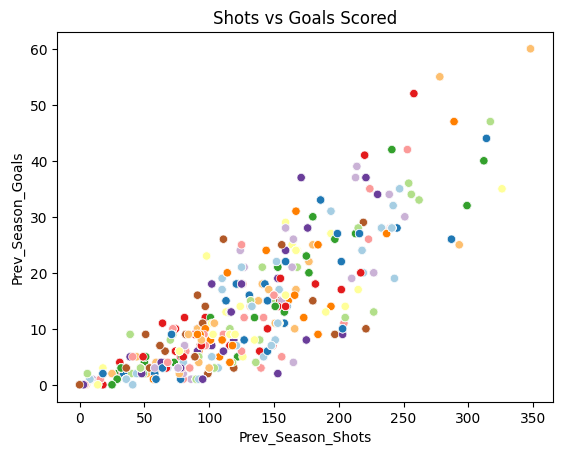

In [ ]:
sns.scatterplot(data=data, x="Prev_Season_Shots", y="Prev_Season_Goals", hue="Player", palette="Paired")
plt.title("Shots vs Goals Scored")
plt.legend([],[], frameon=False) # because we don't need a legend of every single player
plt.show()
# check for null values?

Our dataset also includes a player's position - we think there could be a correlation between position and goals scored (i.e. forwards scoring more than defense), so we'll make the same graph as above but hued by position.

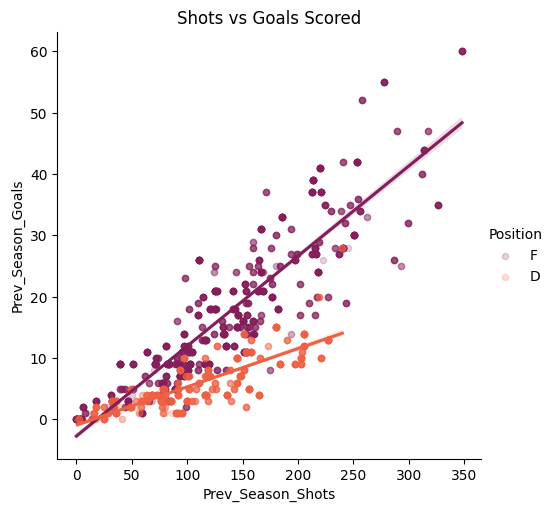

In [ ]:
# assigning players to either F (forward) or D (defense)
binary_pos = {'C': 'F', 'LW': 'F', 'RW': 'F'}
data = data.replace(binary_pos)

sns.lmplot(data=data, x="Prev_Season_Shots", y="Prev_Season_Goals", hue="Position", palette='rocket', scatter_kws={'alpha':0.2, 's':20})
plt.title("Shots vs Goals Scored")
plt.show()

This graph shows that overall, forward players to score more goals in the same amount of shots as defense (and take more shots in general). This could be a very useful predictor.

The player data in our dataset is the outcome from each game (eg. number of goals they scored in that game, number of penalty minutes they had in that game, etc.). We want to predict the number of goals a player will score in a given game *before* the game actually occurs, so we won't use these post game stats in our training or predictions, but looking at the correlations between them and number of goals scored in the game may be interesting. Below is a scatter matrix of all post-game features vs post-game goals.

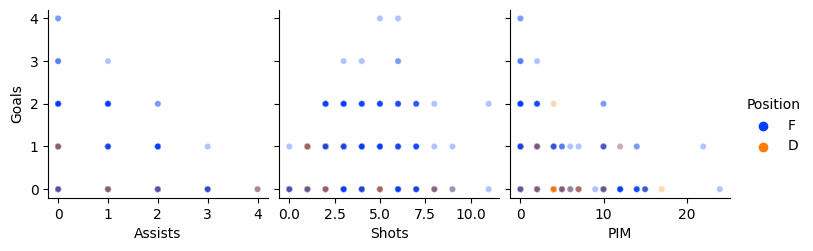

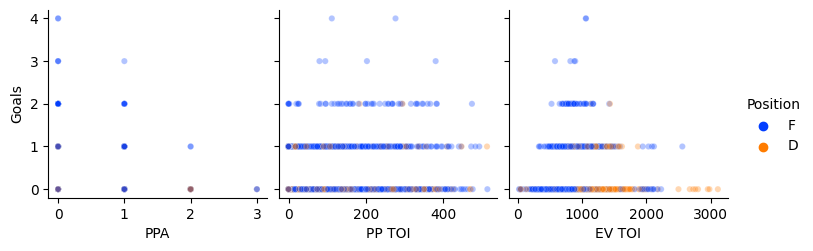

In [ ]:
# doing this because pairplot doesn't support wrapping the charts, only makes one row
post_game_cols1 = ['Assists', 'Shots', 'PIM']
post_game_cols2 = ['PPA', 'PP TOI', 'EV TOI']

# using pairplot because we don't actually want a scatter matrix of the entire dataset, much too big and too many variables
# and not doing any hue because we're just looking at the correlation, not by individual/team/etc.
one = sns.pairplot(data, y_vars='Goals', x_vars=data[post_game_cols1], plot_kws=dict(alpha=0.3, s=20), hue='Position', palette='bright')
two = sns.pairplot(data, y_vars='Goals', x_vars=data[post_game_cols2], plot_kws=dict(alpha=0.3, s=20), hue='Position', palette='bright')

A few observations can be made from the above graphs (though it must be noted that since these are discrete data, it is more difficult to visualize a linear relationship - next we will repeat these graphs with previous season averages, which are continuous data and much more significant than individual game data). Reminder that all of these data are per game data by player.

There is a weak/moderate positive correlation between number of shots and number of goals, as expected. Notably, there are also fairly strong negative correlations between number of assists, number of power play assists, and penalties in minutes vs number of goals. We would expect that penalty minutes decrease a player's time on ice and thus their opportunities to score, but we hadn't considered that number of assists would be negatively correlated. However, we feel that this is an illusory correlation - a player's assists should logically have no impact on their number of goals.

Now, let's drop the post-game values (except goals, our label), and then create some averaged features.

In [ ]:
data.drop(['Assists', 'Scored', 'Shots', 'PIM', 'PPG', 'PPA', 'PP TOI', 'EV TOI'], axis=1, inplace=True)
data.columns = data.columns.str.replace(' ', '_')

categories = ['Prev_Season', 'Total', 'Team_Team', 'Opponent_Team']

for column in data.columns:
    cat = column.split('_')[0]
    feature = column.split('_')[-1]
    if cat in ['Prev', 'Team', 'Opponent']:
        cat = column.split('_')[0] + '_' + column.split('_')[1]
    if cat in categories and feature not in ['GP', 'ID', 'id', 'Date', 'Team', 'Home']:
        data[column] = data[column]/data[cat + '_GP']

for cat in categories:
    data = data.drop([cat + '_GP'], axis=1)

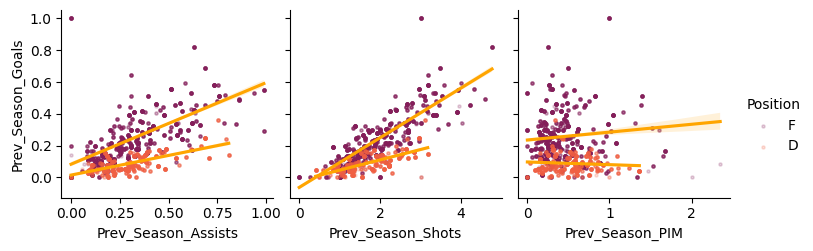

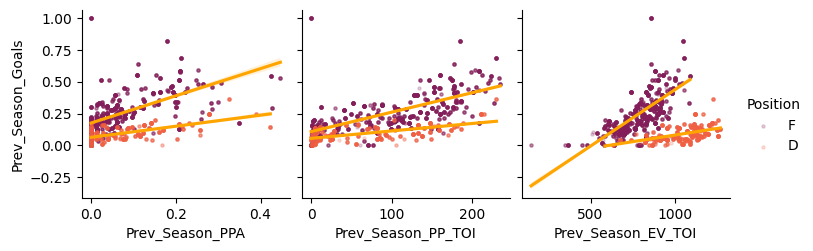

In [ ]:
# doing this because pairplot doesn't support wrapping the charts, only makes one row
post_game_cols1 = ['Prev_Season_Assists', 'Prev_Season_Shots', 'Prev_Season_PIM']
post_game_cols2 = ['Prev_Season_PPA', 'Prev_Season_PP_TOI', 'Prev_Season_EV_TOI']

# using pairplot because we don't actually want a scatter matrix of the entire dataset, much too big and too many variables
one = sns.pairplot(data, y_vars='Prev_Season_Goals', kind='reg', x_vars=data[post_game_cols1], hue='Position', palette='rocket', plot_kws={'line_kws':{'color':'orange'}, 'scatter_kws':{'alpha':0.2, 's':5}})
two = sns.pairplot(data, y_vars='Prev_Season_Goals', kind='reg', x_vars=data[post_game_cols2], hue='Position', palette='rocket', plot_kws={'line_kws':{'color':'orange'}, 'scatter_kws':{'alpha':0.2, 's':5}})

These averaged previous season data show a much clearer correlation between themselves and goals. The player's previous season assists, shots, and PPA are moderately to strongly correlated with their goals. Their power play time on ice is weakly correlated with number of goals. Even strength time on ice looked to have weak correlation with number of goals before they were split by position, which showed that it is significant for forwards but not defencemen. Penalty minutes have no significant correlation with number of goals, meaning they will likely not help with our predictions and we can drop them. And finally, in every graph except PIM vs Goals (since there is no relationship), forwards have higher overall numbers of goals. This means a player's position will be extremely helpful in predicting their goals per game.

Now, we're going to compute the correlation matrix of goals versus all of the other penalty minute columns (e.g. Total_PIM, Team_Team_PIM, Prev_Season_PIM, etc.) in case they also have no impact on goals.

In [ ]:
pim_corr_df = data[['Goals', 'Total_PIM', 'Team_Team_PIM', 'Team_Opponent_PIM',
                      'Opponent_Team_PIM', 'Opponent_Opponent_PIM']]
pim_corr_df.corr()

,Goals,Total_PIM,Team_Team_PIM,Team_Opponent_PIM,Opponent_Team_PIM,Opponent_Opponent_PIM
Goals,1.000000,-0.010572,-0.003426,-0.004331,-0.024260,-0.011131
Total_PIM,-0.010572,1.000000,0.191603,-0.131415,0.155212,-0.131444
Team_Team_PIM,-0.003426,0.191603,1.000000,0.210901,0.722730,0.168880
Team_Opponent_PIM,-0.004331,-0.131415,0.210901,1.000000,0.168880,0.905531
Opponent_Team_PIM,-0.024260,0.155212,0.722730,0.168880,1.000000,0.210901
Opponent_Opponent_PIM,-0.011131,-0.131444,0.168880,0.905531,0.210901,1.000000


All of the correlation values with goals are very low - this indicates no real relationship between PIM and goals. So, we'll remove the PIM columns from our data.

In [ ]:
# dropping Prev_Season_PIM and Prev_Season_EV_TOI since they have no correlation
# to goals
data.drop(['Prev_Season_PIM', 'Prev_Season_EV_TOI', 'Total_PIM', 'Team_Team_PIM', 'Team_Opponent_PIM',
                      'Opponent_Team_PIM', 'Opponent_Opponent_PIM'], axis=1, inplace=True)


Currently, our df still contains player IDs and game IDs, which we don't want to be used in training, but might want later to predict specific players or games. We'll save a copy of the data frame as is, then drop these values from the df we're going to use for training/prediction.

In [ ]:
df_with_IDs = data.copy()
data.drop(['game_id'], axis=1, inplace=True)
# dropping stuff manually for now until file is updated
data.drop(['Opponent_Opponent',
              'Opponent_Team', 'Opponent_Home'], axis=1, inplace=True)

data = data.replace(np.nan, None)

Note: we elected to use MinMaxScaler instead of StandardScaler because we want all our feature values to be non-negative.

In [ ]:
col_names = list(data.drop('Goals', axis=1).columns)
# removing cat_feature names from num_feature list
cat_features = ['Team_Home', 'Team_Team', 'Team_Opponent', 'Position']
for feature in cat_features:
  col_names.remove(feature)
col_names.remove('Player')
num_features = col_names

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                                ('scaler', MinMaxScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) ])

# creating a column transformer to apply the num and cat pipelines
preprocessor = ColumnTransformer( [('num', num_pipeline, num_features),
                                  ('cat', cat_pipeline, cat_features)],
                                    remainder='passthrough' )

# get_feature_names_out() to maintin column names
y = data['Goals']
X = data.drop('Goals', axis=1)

# use train_test_split() to split the data into training and test sets/labels
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.2,
                                                    random_state=42)

train_ID = X_train['Player']
X_train.drop(['Player'], axis=1, inplace=True)
test_ID = X_test['Player']
X_test.drop(['Player'], axis=1, inplace=True)

len(X_train), len(X_test)

(2534, 634)

#To train our data, we've opted to utilize the following three models: SGD Regressor, Support Vector Machine, and Decision Tree Regressor.

### SGD Regressor

We'll start by predicting player scoring probabilities using the SGD Regressor model. We're starting with SGD Regressor because of its capability to fine-tune parameters by each data point to minimize the overall prediction error.

In [ ]:
# SGD Regressor on entire dataset:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01)
SGD_Pipeline = Pipeline([('preprocessor', preprocessor),
                            ('SGD', sgd_reg)])
SGD_Pipeline.fit(X_train, y_train)
sgd_pred = SGD_Pipeline.predict(X_test)

sgd_mse = mean_squared_error(y_test, sgd_pred, squared=False)
sgd_rmse = np.sqrt(sgd_mse) # to compare to SVM and DTR RMSE later

In [ ]:
sgd_df = pd.DataFrame({
    'Player': test_ID,
    'Predicted': sgd_pred,
    'Actual': y_test
})
sgd_df = sgd_df.groupby(['Player']).mean()

Testing SGD on one player:

In [ ]:
player_ids = ['ID8480069', 'ID8478402', 'ID8477447']
player_id = player_ids[0]

train_player_X = df_with_IDs.copy()[df_with_IDs['Player'] != player_id]
train_player_y = train_player_X['Goals']
train_player_X.drop(['Player', 'game_id', 'Goals', 'Opponent_Opponent',
              'Opponent_Team', 'Opponent_Home'], axis=1, inplace=True)
test_player_X = df_with_IDs.copy()[df_with_IDs['Player'] == player_id]
test_player_y = test_player_X['Goals']
test_player_X.drop(['Player', 'game_id', 'Goals', 'Opponent_Opponent',
              'Opponent_Team', 'Opponent_Home'], axis=1, inplace=True)

SGD_Pipeline.fit(train_player_X, train_player_y)
test_player_y_predict = SGD_Pipeline.predict(test_player_X)

In [ ]:
for i in range(len(test_player_y_predict)):
    print("Predicted: ", test_player_y_predict[i], "Actual: ", test_player_y.iloc[i])

Predicted:  0.2344414159859966 Actual:  0
Predicted:  0.32535649741956646 Actual:  0
Predicted:  0.2652100671489644 Actual:  1
Predicted:  0.29143731910811144 Actual:  0
Predicted:  0.258678526795279 Actual:  0
Predicted:  0.2876813842257626 Actual:  0


### Support Vector Machines

We are using SVMs since they are capable of working with small to medium datasets. Our regularization parameter, C, will help control the tradeoff between fitting the data well and maintaining a simpler model. The regularization parameter will help prevent overfitting with any unseen data. SVM will help us obtain non-linear dependencies between the player's features and the number of goals they score. Since we have a higher number of features, SVM can help us with our higher-dimensional data to provide an optimal hyperplane or decision boundary. Since we are trying to calculate the number of goals, our target variable is a continuous one, so support vector regression techniques will be useful.

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#we used the commented code below to find the best hyperparameters
# # Create a dictionary of hyperparameters to search
# param_grid = {'C': [0.1, 1, 10],
#                 'gamma': [1, 0.1, 0.01],
#                 'kernel': ['rbf']}
# # Instantiate GridSearchCV
# grid_search = GridSearchCV(SVR(), param_grid, cv=5,
#                             scoring='neg_mean_squared_error',
#                             return_train_score=True)

# # Fit to the data
# grid_search.fit(X_train, y_train)
# # Find the best hyperparameters
# print(grid_search.best_params_)
# # Find the best estimator
# print(grid_search.best_estimator_)
# # Find the best score
# print(grid_search.best_score_)

In [ ]:
svr = SVR(kernel='rbf', C=1, gamma=0.1, epsilon=.1)

SVR_Pipeline = Pipeline([('preprocessor', preprocessor),
                            ('svr', svr)])

In [ ]:
# Find the RMSE
SVR_Pipeline.fit(X_train, y_train)
svr_pred = SVR_Pipeline.predict(X_test)

svr_mse = mean_squared_error(y_test, svr_pred, squared=False)
svr_rmse = np.sqrt(svr_mse) # to compare with SGD and DTR RMSE later

In [ ]:
svr_df = pd.DataFrame({
    'Player': test_ID,
    'Predicted': svr_pred,
    'Actual': y_test
})
svr_df = svr_df.groupby(['Player']).mean()

Testing SVM on one player:

In [ ]:
player_ids = ['ID8480069', 'ID8478402', 'ID8477447']
player_id = player_ids[0]

train_player_X = df_with_IDs.copy()[df_with_IDs['Player'] != player_id]
train_player_y = train_player_X['Goals']
train_player_X.drop(['Player', 'game_id', 'Goals', 'Opponent_Opponent',
              'Opponent_Team', 'Opponent_Home'], axis=1, inplace=True)
test_player_X = df_with_IDs.copy()[df_with_IDs['Player'] == player_id]
test_player_y = test_player_X['Goals']
test_player_X.drop(['Player', 'game_id', 'Goals', 'Opponent_Opponent',
              'Opponent_Team', 'Opponent_Home'], axis=1, inplace=True)

SVR_Pipeline.fit(train_player_X, train_player_y)
test_player_y_predict = SVR_Pipeline.predict(test_player_X)

In [ ]:
for i in range(len(test_player_y_predict)):
    print("Predicted: ", test_player_y_predict[i], "Actual: ", test_player_y.iloc[i])

Predicted:  0.1043475904368561 Actual:  0
Predicted:  0.11697828117857215 Actual:  0
Predicted:  0.1214761896761449 Actual:  1
Predicted:  0.10711861901773048 Actual:  0
Predicted:  0.11219069557256109 Actual:  0
Predicted:  0.11144558227831905 Actual:  0


### Decision Tree Regressor

Now, we will predict player scoring probabilities using the Decision Tree Regressor model. Initially, our plan was to implement the Random Forest Regressor model but due to the substantial amount of training instances in our data, the time required to generate the subsets in RFR became a concern.

We've opted for the DTR for it's ability to handle categorical and numerical values in our dataset - as well as the ability to handle a medium-sized dataset.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
DT_Pipeline = Pipeline([('preprocessor', preprocessor),
                            ('DecisionTreeRegressor', tree_reg)])
DT_Pipeline.fit(X_train, y_train)

dtr_pred = DT_Pipeline.predict(X_test)

dtr_mse = mean_squared_error(y_test, dtr_pred, squared=False)
dtr_rmse = np.sqrt(dtr_mse) # to compare with SGD and SVM RMSE later

In [ ]:
dtr_df = pd.DataFrame({
    'Player': test_ID,
    'Predicted': dtr_pred,
    'Actual': y_test
})
dtr_df = dtr_df.groupby(['Player']).mean()

Testing Decision Tree on one player:

In [ ]:
player_ids = ['ID8480069', 'ID8478402', 'ID8477447']
player_id = player_ids[0]

train_player_X = df_with_IDs.copy()[df_with_IDs['Player'] != player_id]
train_player_y = train_player_X['Goals']
train_player_X.drop(['Player', 'game_id', 'Goals', 'Opponent_Opponent',
              'Opponent_Team', 'Opponent_Home'], axis=1, inplace=True)
test_player_X = df_with_IDs.copy()[df_with_IDs['Player'] == player_id]
test_player_y = test_player_X['Goals']
test_player_X.drop(['Player', 'game_id', 'Goals', 'Opponent_Opponent',
              'Opponent_Team', 'Opponent_Home'], axis=1, inplace=True)

DT_Pipeline.fit(train_player_X, train_player_y)
test_player_y_predict = DT_Pipeline.predict(test_player_X)

In [ ]:
for i in range(len(test_player_y_predict)):
    print("Predicted: ", test_player_y_predict[i], "Actual: ", test_player_y.iloc[i])

Predicted:  0.0 Actual:  0
Predicted:  1.0 Actual:  0
Predicted:  0.0 Actual:  1
Predicted:  1.0 Actual:  0
Predicted:  0.0 Actual:  0
Predicted:  1.0 Actual:  0


#Scatterplots to visualize each model's predictions:

SGD Regressor RMSE: 0.6355783921960698
SVR RMSE: 0.6488345705738519
DTR RMSE: 0.7657584695153777


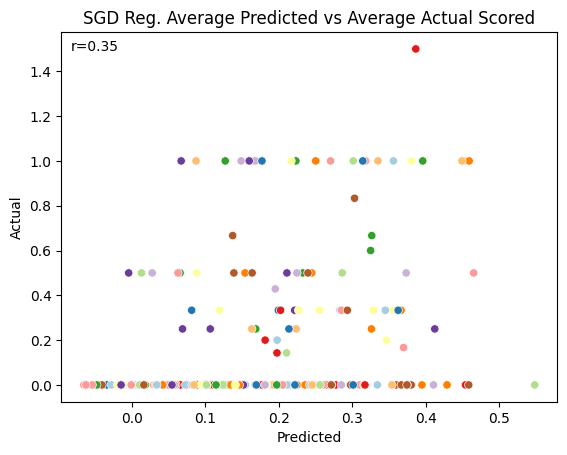

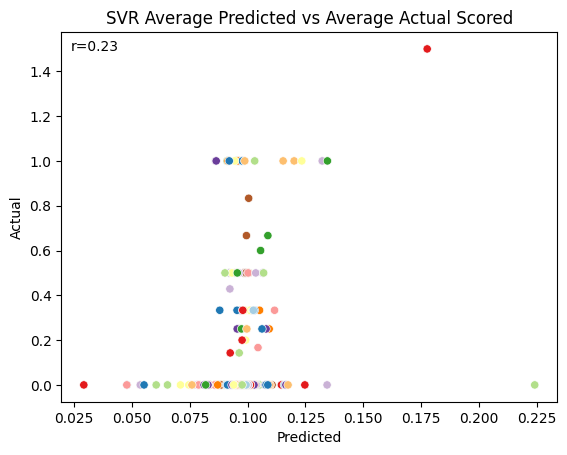

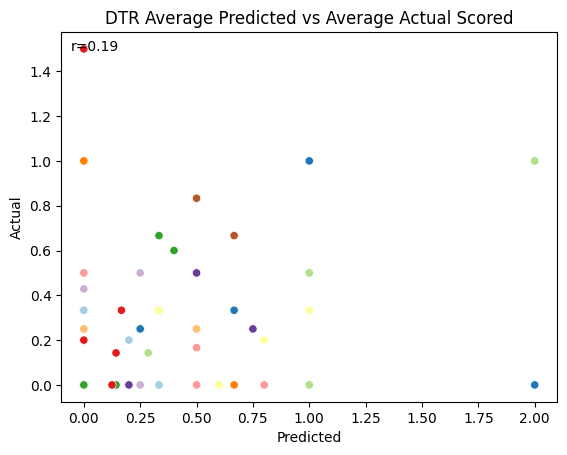

In [ ]:
# comparing RMSEs
print("SGD Regressor RMSE: " + str(sgd_rmse))
print("SVR RMSE: " + str(svr_rmse))
print("DTR RMSE: " + str(dtr_rmse))

import scipy as sp # to calculate r values below

sgd_r, sgd_p = sp.stats.pearsonr(sgd_df["Predicted"], sgd_df["Actual"])
sgd_r_str = 'r={:.2f}'.format(sgd_r)

sns.scatterplot(data=sgd_df, x="Predicted", y="Actual", hue="Player", palette="Paired")
plt.title("SGD Reg. Average Predicted vs Average Actual Scored")
plt.text(.02, .98, sgd_r_str, ha='left', va='top', transform=plt.gca().transAxes)
plt.legend([],[], frameon=False) # because we don't need a legend of every single ID
plt.show()

svr_r, svr_p = sp.stats.pearsonr(svr_df["Predicted"], svr_df["Actual"])
svr_r_str = 'r={:.2f}'.format(svr_r)

sns.scatterplot(data=svr_df, x="Predicted", y="Actual", hue="Player", palette="Paired")
plt.title("SVR Average Predicted vs Average Actual Scored")
plt.text(.02, .98, svr_r_str, ha='left', va='top', transform=plt.gca().transAxes)
plt.legend([],[], frameon=False)
plt.show()

dtr_r, dtr_p = sp.stats.pearsonr(dtr_df["Predicted"], dtr_df["Actual"])
dtr_r_str = 'r={:.2f}'.format(dtr_r)

sns.scatterplot(data=dtr_df, x="Predicted", y="Actual", hue="Player", palette="Paired")
plt.title("DTR Average Predicted vs Average Actual Scored")
plt.text(.02, .98, dtr_r_str, ha='left', va='top', transform=plt.gca().transAxes)
plt.legend([],[], frameon=False)
plt.show()

The above graphs show the SGD Regressor's predictions are the most strongly correlated with the actual values (r=) and so it would be the model of choice were we to continue this project. The Decision Tree model classifies the values as integers, which is not consistent with our desired output, so it's the worst of the models for our goal.

An issue with our approach is that the current season data will always be averaged on a small sample size early in the season, and large sample size later in the season. Some possible ways to counteract this could be using a weighted average between the previous season statistics and the current season ones, giving more weight to the current season ones, and more weight depending on how many games have been played. Another way would be changing the impact of current season statistics on the model depending on the games played.